<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [1]:

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math
import sys
sys.path.append("../../")
from src import Soporte_eda

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

In [2]:
df = pd.read_csv("../../../datos/df_datosrobustos.csv",index_col= 0)
df.head()

,price_knn,powerCV_knn_robust
0,480.0,-0.481159
1,18300.0,1.086957
2,9800.0,0.710145
3,1500.0,-0.550725
4,3600.0,-0.637681


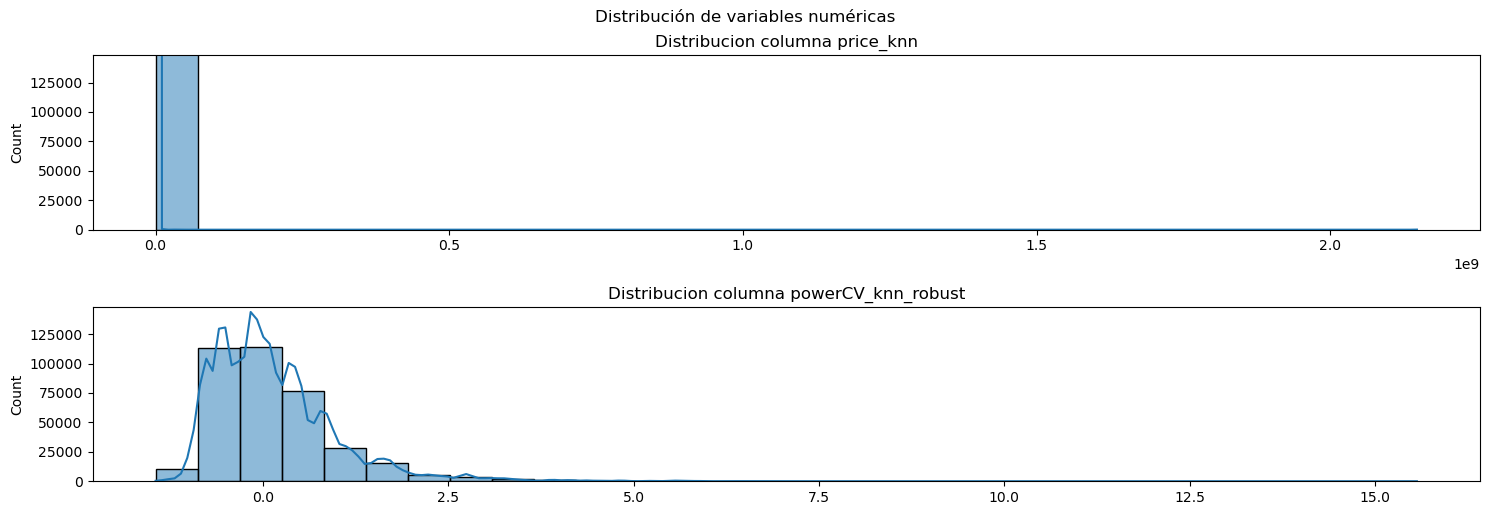

In [3]:
#Emplearemos nuesto dataframe ya limpio sin nulos y con únicamente las variables numéricas. Usamos el escalado robusto.
df.head()

#Comenzamos con un análisis visual
Soporte_eda.visual_outliers(df,df.columns,tipo_grafica= "h")

In [4]:
df.describe()

,price_knn,powerCV_knn_robust
count,3.713460e+05,371346.000000
mean,1.729561e+04,0.149810
std,3.588832e+06,0.880249
min,0.000000e+00,-1.449275
25%,1.150000e+03,-0.478261
50%,2.950000e+03,0.000000
75%,7.200000e+03,0.521739
max,2.147484e+09,15.565217


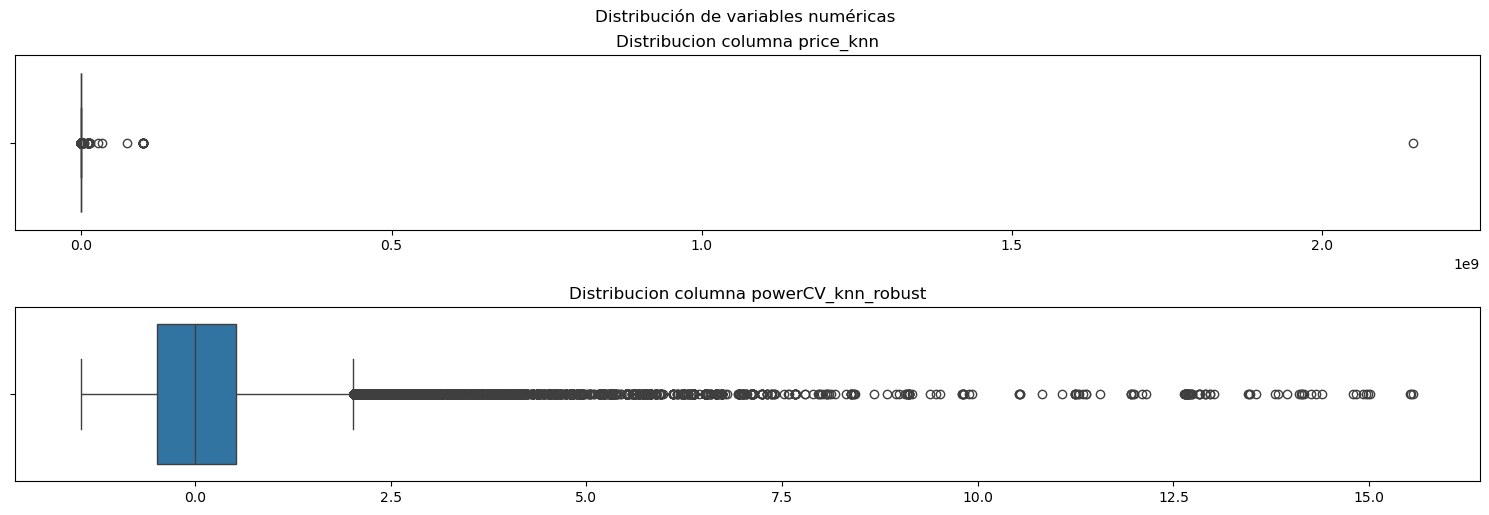

In [5]:
#Emplearemos nuesto dataframe ya limpio sin nulos y con únicamente las variables numéricas. Usamos el escalado robusto.
df.head()

#Comenzamos con un análisis visual
Soporte_eda.visual_outliers(df,df.columns,tipo_grafica= "b")

In [6]:
lista_columnas = df.columns
lista_columnas
outliers = Soporte_eda.identificar_outliers_iqr(df,lista_columnas)


la columna price_knn tiene 28093 outliers
la columna powerCV_knn_robust tiene 12419 outliers


In [7]:
k = 1.5
for columna in df.columns:
    Q1, Q3 = np.nanpercentile(df[columna], (25,75))
    iqr = Q3-Q1
    limite_superior = Q3 + (iqr*k)
    limite_inferior = Q1 - (iqr*k)

    condicion_superior = df[columna] > limite_superior
    condicion_inferior = df[columna] < limite_inferior

    df_outliers = df[condicion_inferior | condicion_superior]

df_outliers.head()

,price_knn,powerCV_knn_robust
41,7500.0,2.753623
56,39600.0,2.753623
60,1.0,2.463768
104,22999.0,2.710145
117,6300.0,2.159420


In [8]:
contaminacion = [0.01, 0.05,0.1]
estimadores = [1000,1500,2000]

In [9]:
combinaciones_ifo = list(product(contaminacion,estimadores))
combinaciones_ifo


[(0.01, 1000),
 (0.01, 1500),
 (0.01, 2000),
 (0.05, 1000),
 (0.05, 1500),
 (0.05, 2000),
 (0.1, 1000),
 (0.1, 1500),
 (0.1, 2000)]

In [10]:
df_test_ifo = df.copy()
df_test_lof = df.copy()
df_test_dbscan = df.copy()

In [11]:

combinaciones_ifo = list(product(contaminacion,estimadores))
for cont, esti in combinaciones_ifo:

    ifo = IsolationForest(random_state = 42,
                        n_estimators = esti,
                        contamination = cont,
                        n_jobs = -1)

    df_test_ifo[f"outliers_ifo_{cont}_{esti}"]=(ifo.fit_predict(df[["powerCV_knn_robust"]]))

   


In [12]:
df_test_ifo["powerCV_knn_robust"].describe()

count    371346.000000
mean          0.149810
std           0.880249
min          -1.449275
25%          -0.478261
50%           0.000000
75%           0.521739
max          15.565217
Name: powerCV_knn_robust, dtype: float64

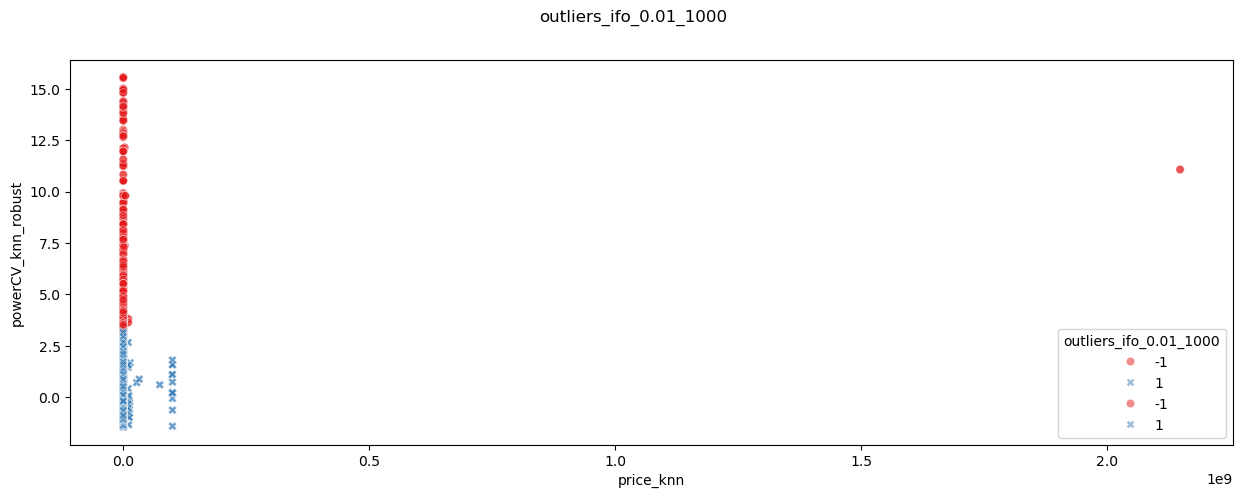

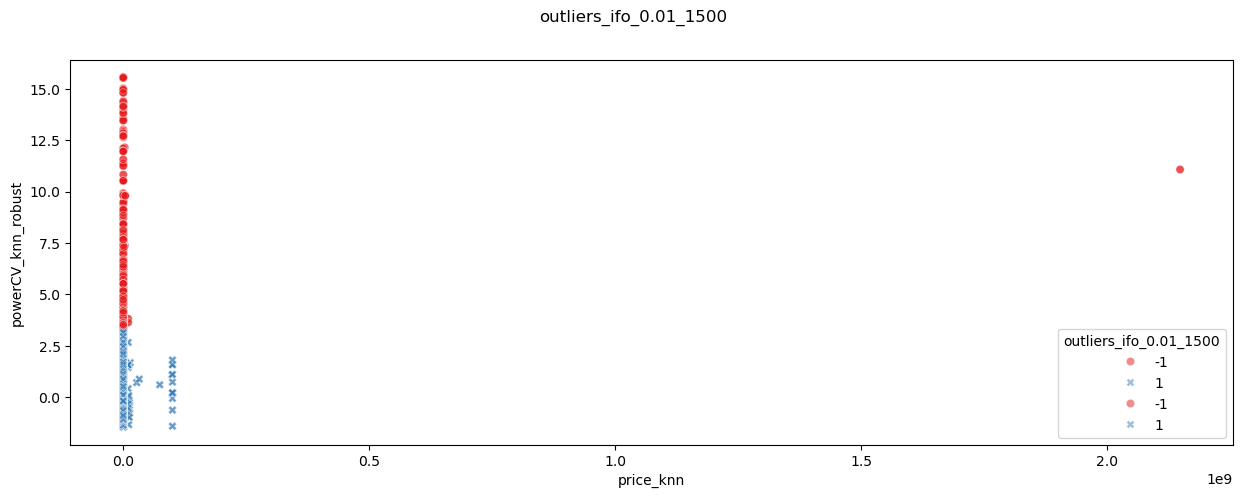

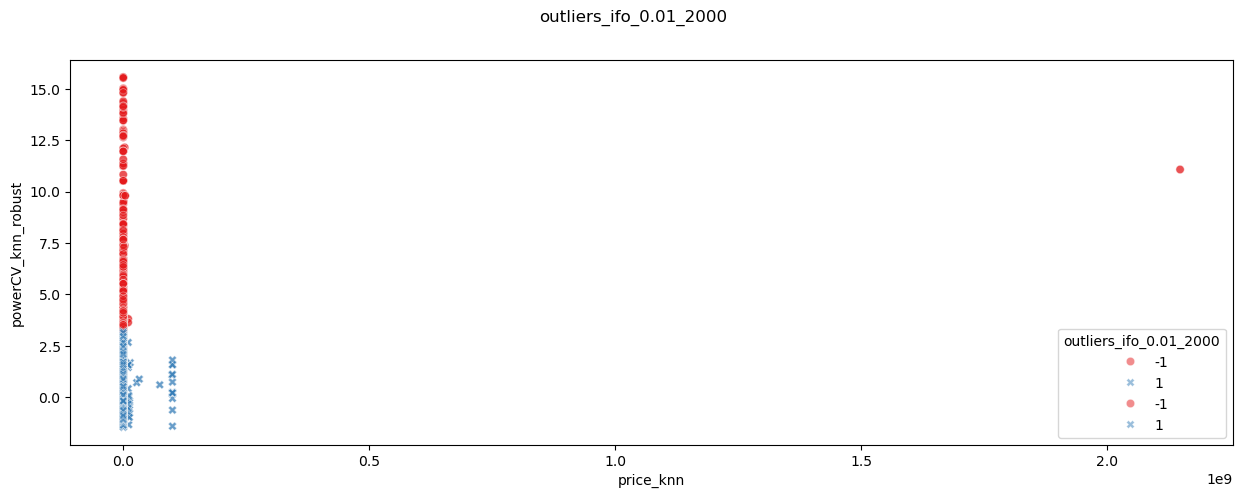

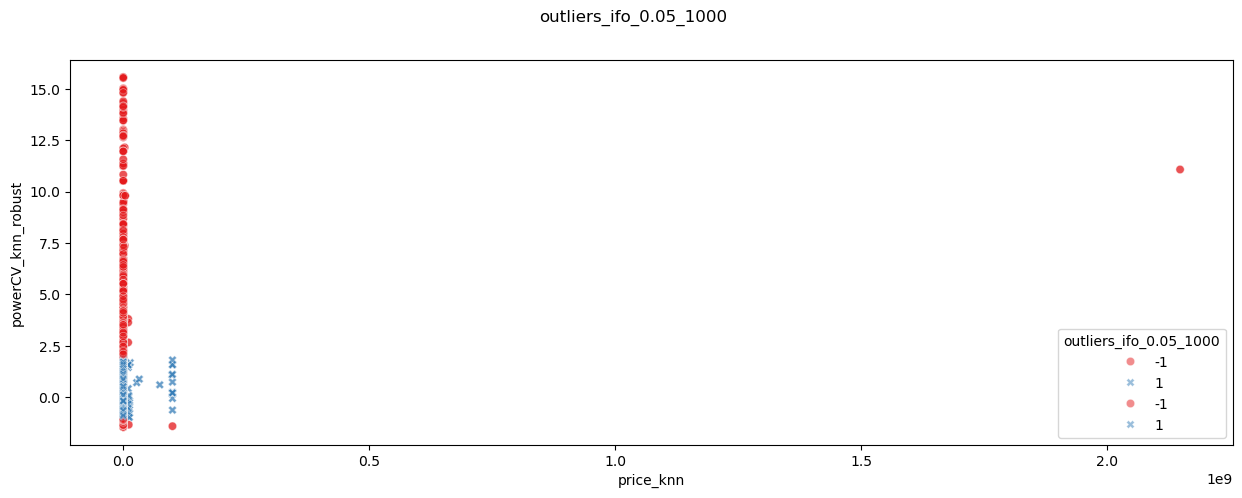

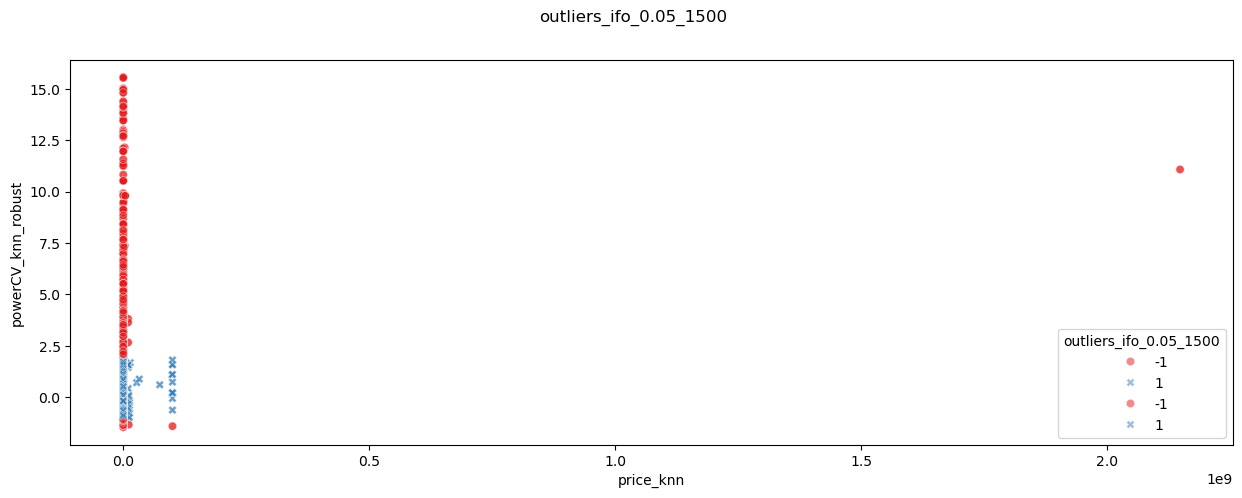

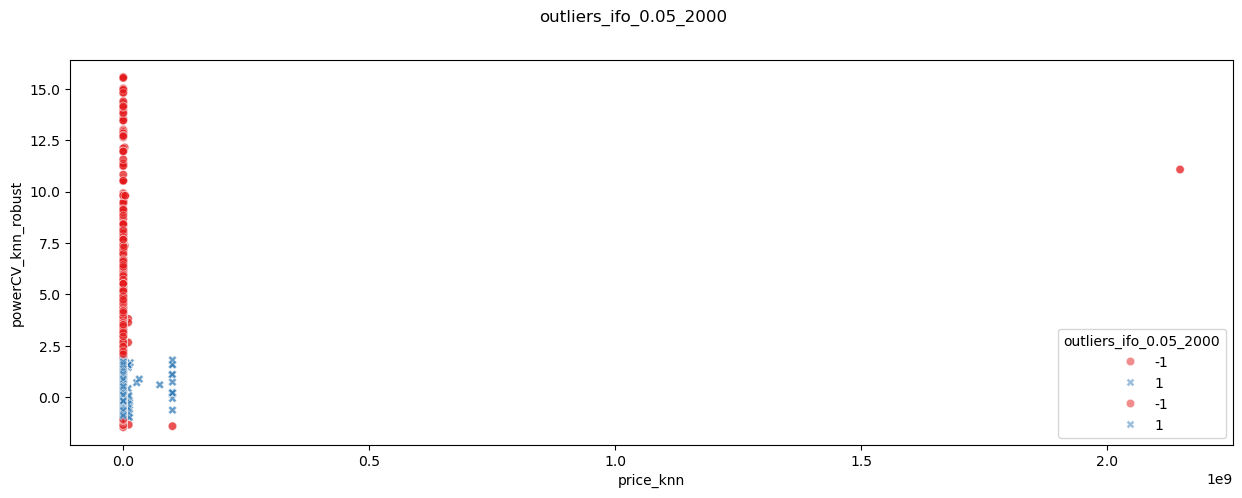

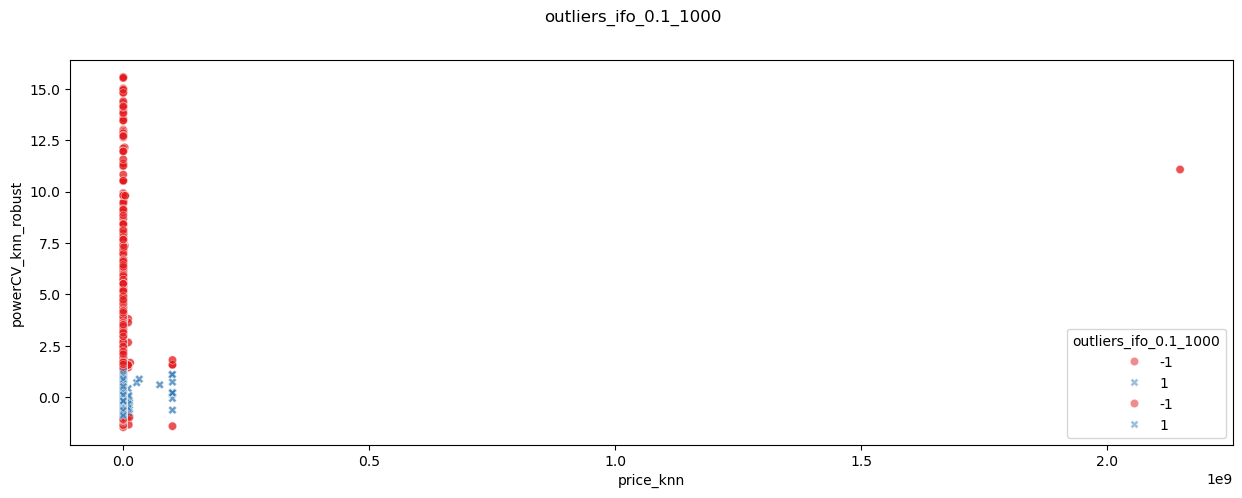

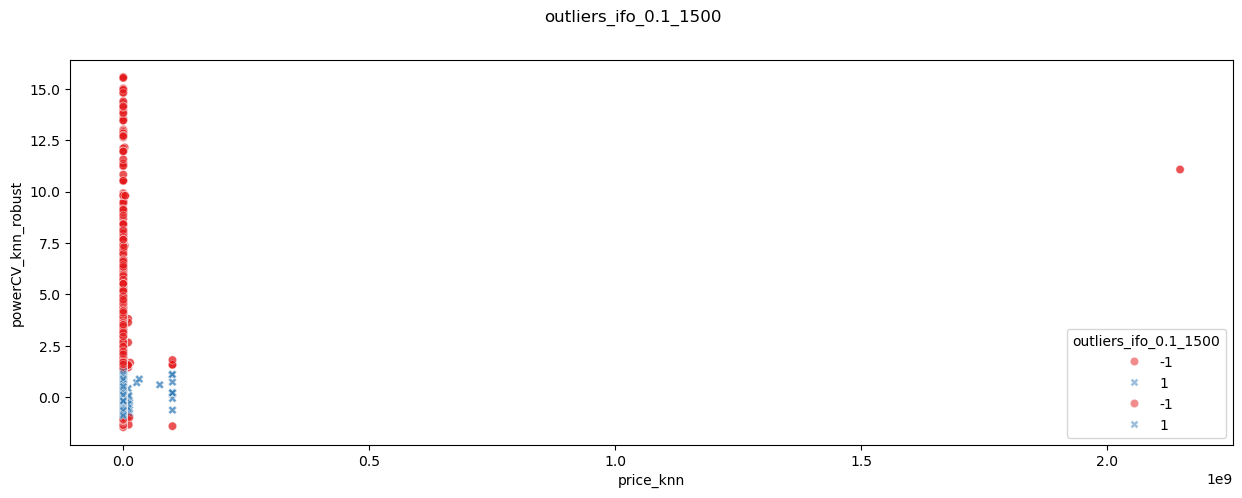

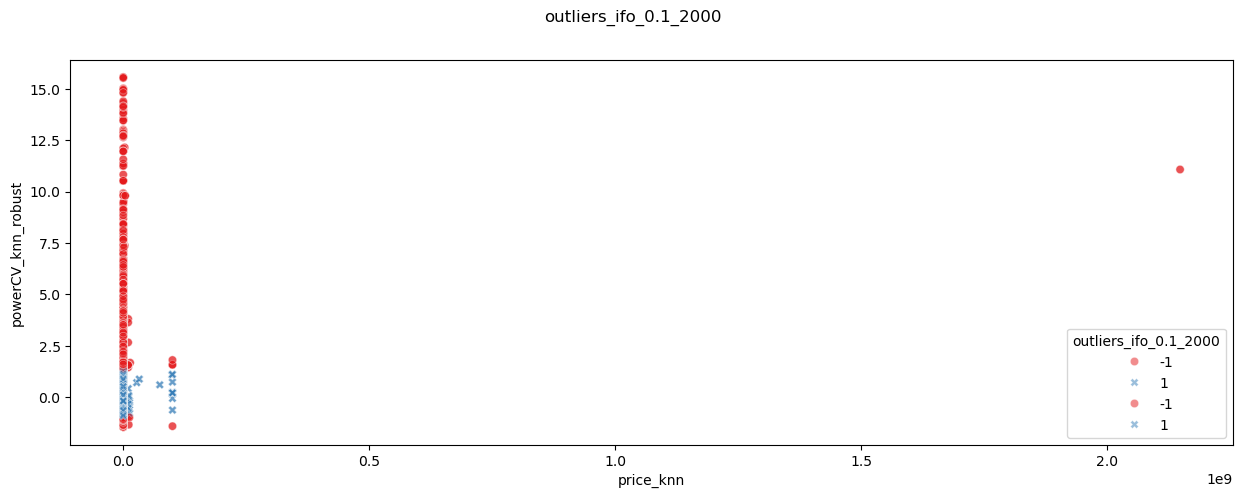

In [13]:
lista = ["price_knn","powerCV_knn_robust"]
columnas_hue = df_test_ifo.filter(like="outlier").columns

for outlier in columnas_hue:
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize =  (15,5))
    # axes = axes.flat

    for indice, tupla in enumerate(lista):
        sns.scatterplot ( x= lista[0],
                         y = lista [1],
                        #  ax = axes[indice],
                         data= df_test_ifo,
                         hue = outlier,
                         palette = "Set1",
                         style = outlier,
                         alpha = 0.5)
        
    plt.suptitle(outlier)


Encontramos un outlier que nos ditorsiona la escala alrededor de los 10 caballos y con más de 10 millones de euros, lo eliminamos para poder escalar 

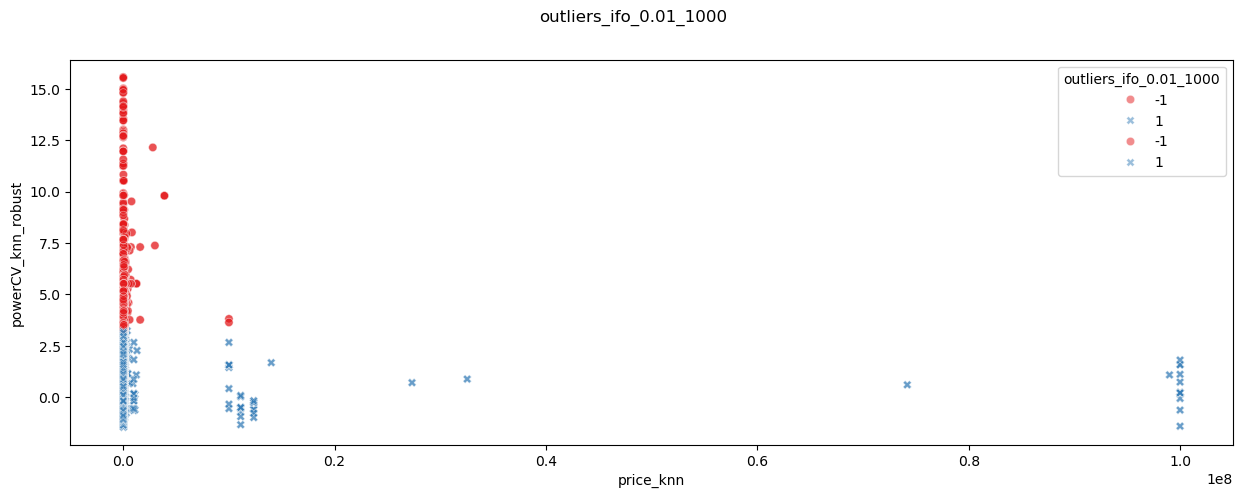

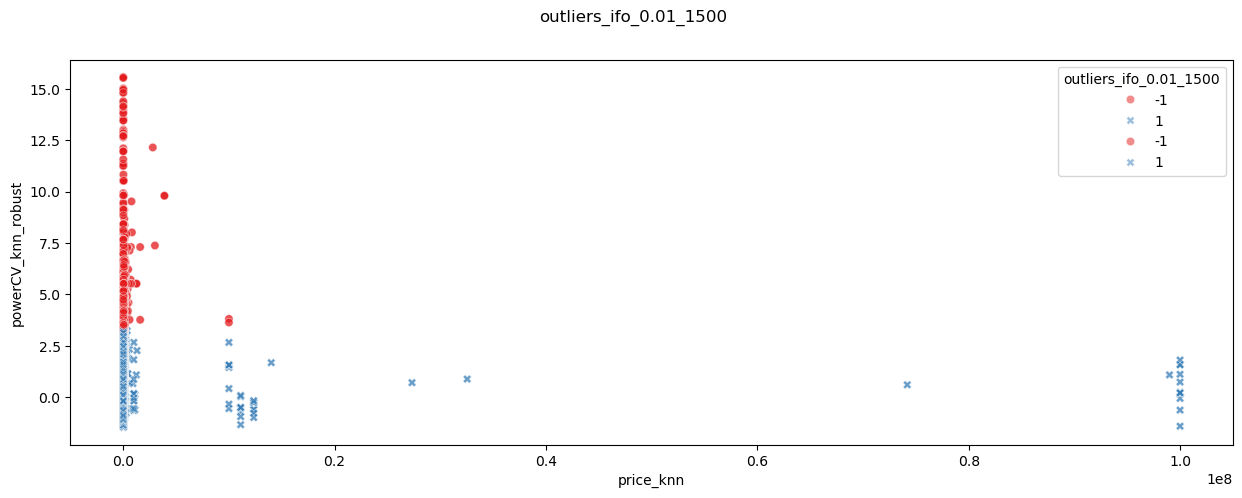

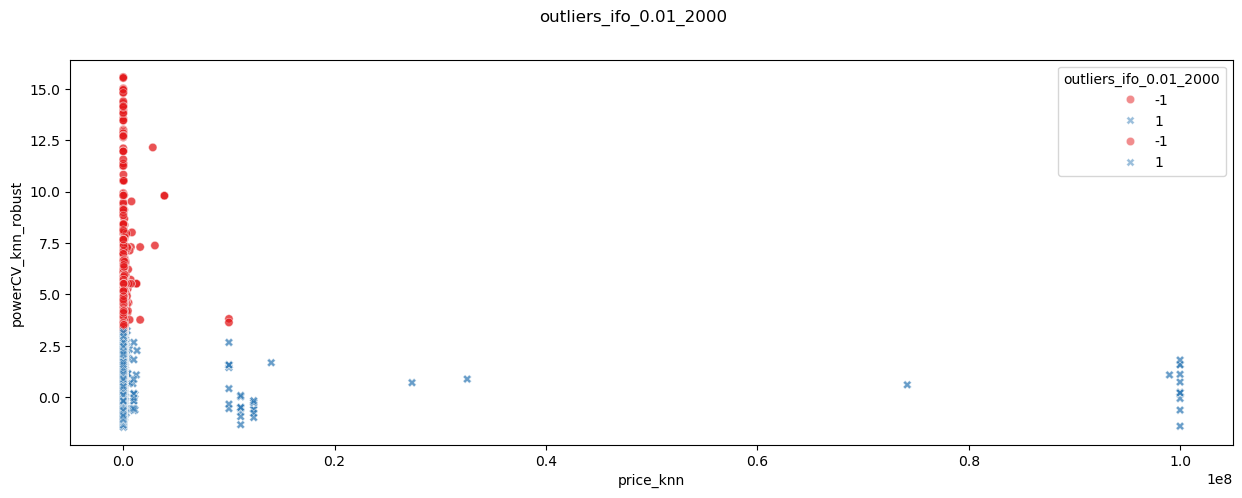

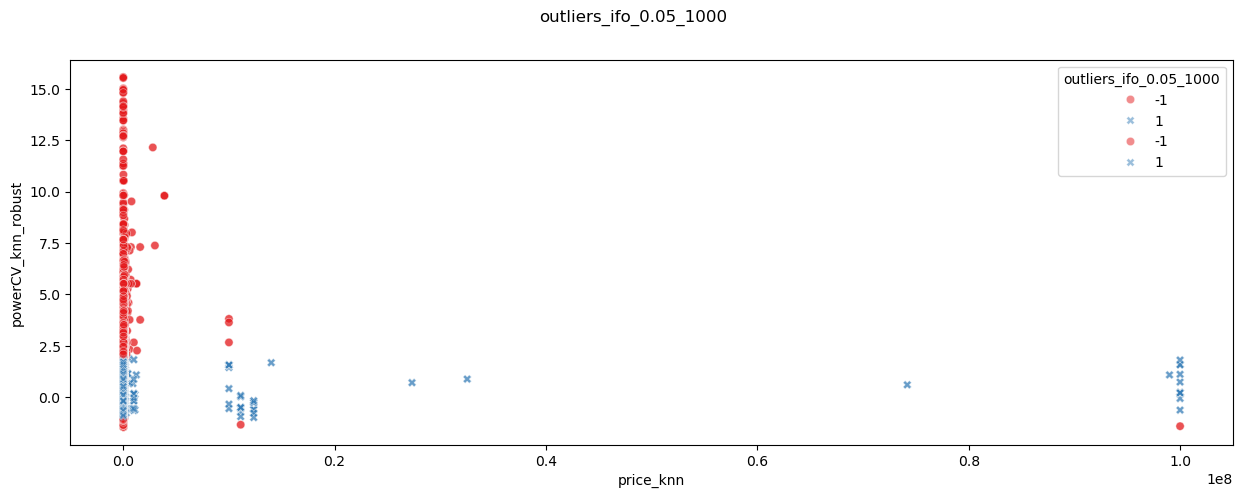

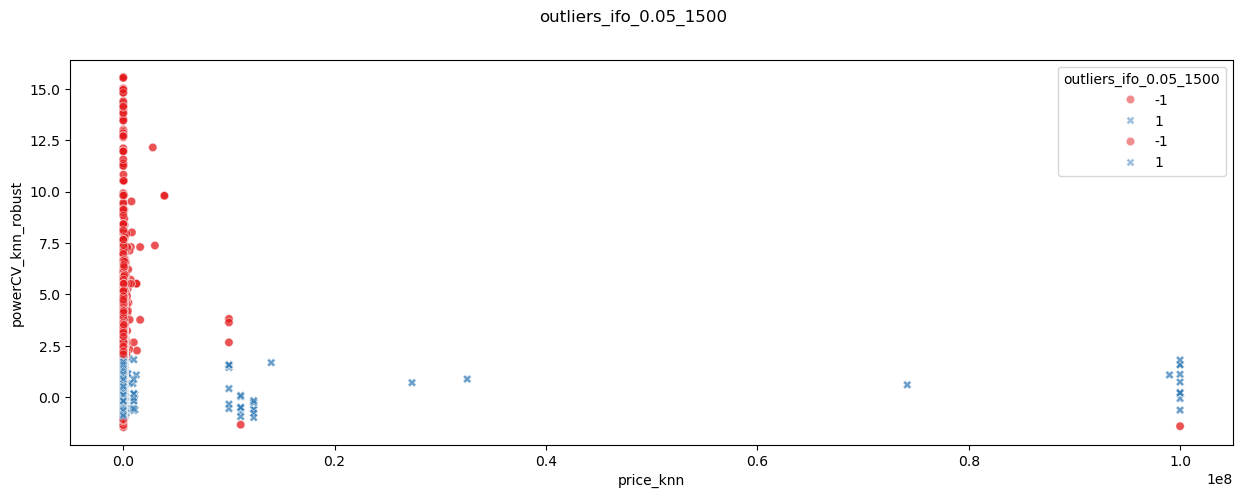

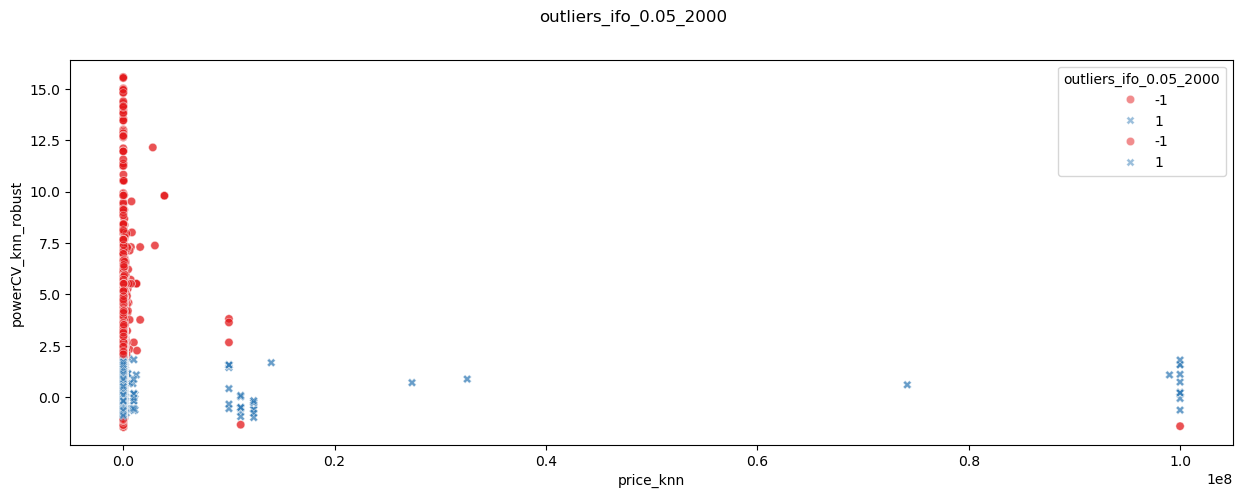

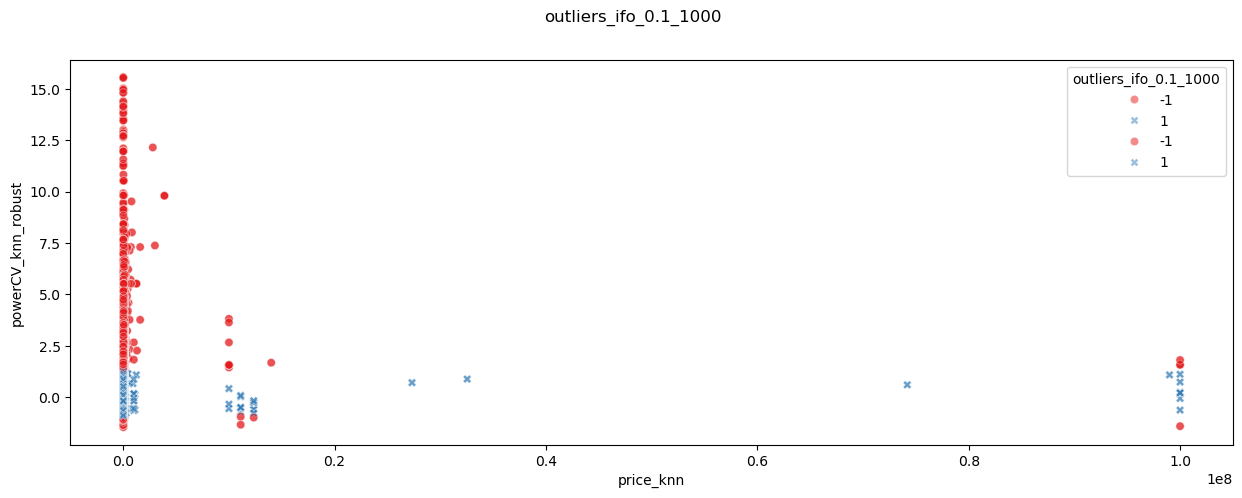

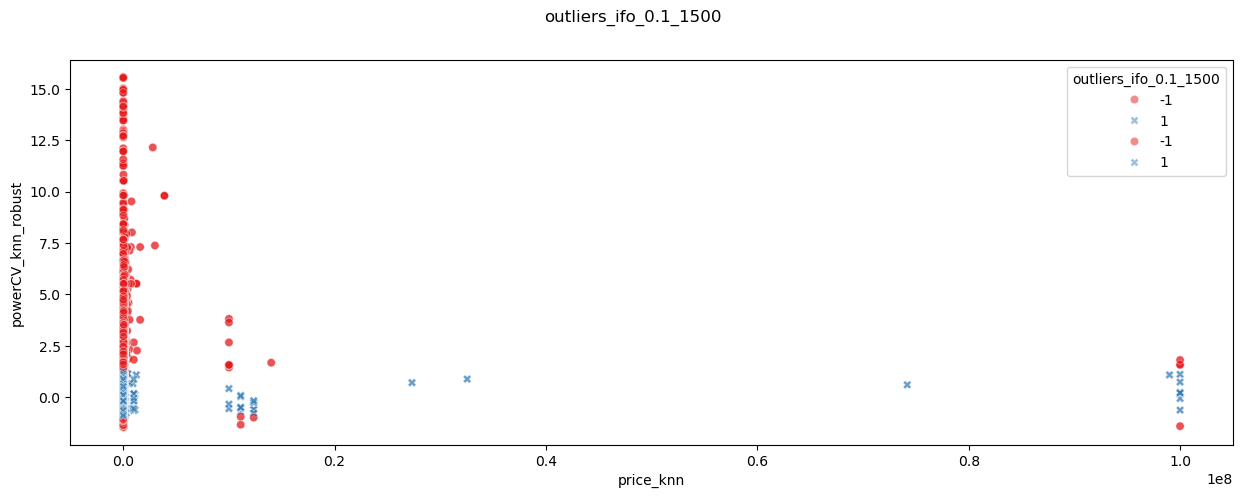

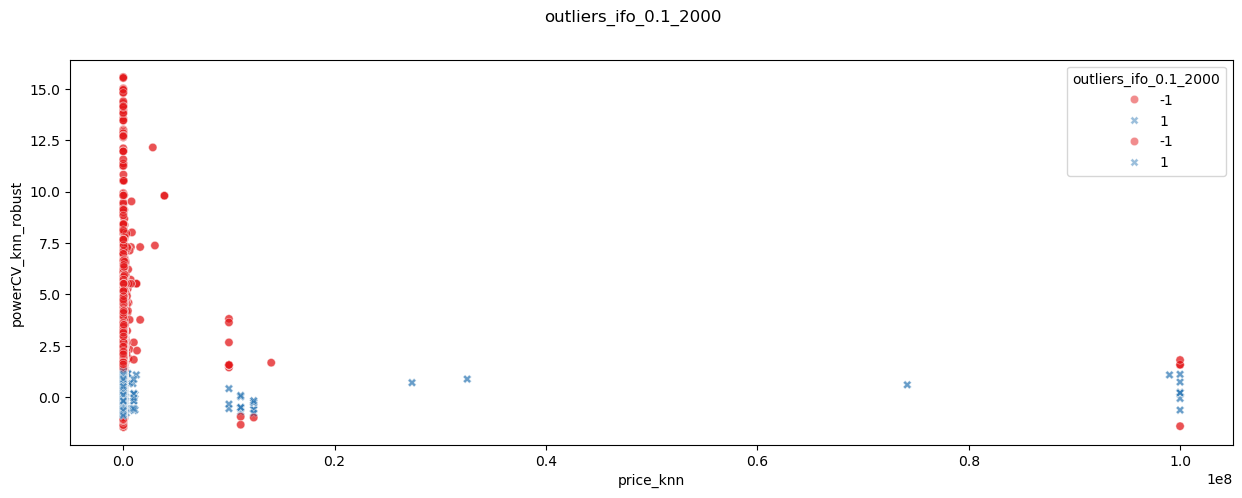

In [14]:
#Eliminamos el outlier y volvemos a visualizar
outlier_singular = df_test_ifo[df_test_ifo["price_knn"] > 200000000]

df_test_ifo = df_test_ifo[df_test_ifo["price_knn"] <= 200000000]

lista = ["price_knn","powerCV_knn_robust"]
columnas_hue_ifo = df_test_ifo.filter(like="outlier").columns

for outlier in columnas_hue_ifo:
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize =  (15,5))
    # axes = axes.flat

    for indice, tupla in enumerate(lista):
        sns.scatterplot ( x= lista[0],
                         y = lista [1],
                        #  ax = axes[indice],
                         data= df_test_ifo,
                         hue = outlier,
                         palette = "Set1",
                         style = outlier,
                         alpha = 0.5)
        
    plt.suptitle(outlier)


Observamos que la mayoría de los outliers para los caballos están en coches por encima de la mediana, y si aumentamos la cantidad de outliers admisibles vemos que por encima del percentil 30 hay una mayoría de valores atípcos. La cantidad de iteraciones que tenemos no parece afectar fuertemente en los outliers detectados. Tal vez el isolation forest no sea la mejor opción para tratar los datos, pues están relativamente agrupados. Asimismo, el rango de selección de los detos en la limpieza era correcto, por lo que no es interesante eliminar esos valores aunque sean correctos.

In [15]:
df_test_ifo

,price_knn,powerCV_knn_robust,outliers_ifo_0.01_1000,outliers_ifo_0.01_1500,outliers_ifo_0.01_2000,outliers_ifo_0.05_1000,outliers_ifo_0.05_1500,outliers_ifo_0.05_2000,outliers_ifo_0.1_1000,outliers_ifo_0.1_1500,outliers_ifo_0.1_2000
0,480.0,-0.481159,1,1,1,1,1,1,1,1,1
1,18300.0,1.086957,1,1,1,1,1,1,1,1,1
2,9800.0,0.710145,1,1,1,1,1,1,1,1,1
3,1500.0,-0.550725,1,1,1,1,1,1,1,1,1
4,3600.0,-0.637681,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
371341,2200.0,0.104348,1,1,1,1,1,1,1,1,1
371342,1199.0,-0.173913,1,1,1,1,1,1,1,1,1
371343,9200.0,-0.159420,1,1,1,1,1,1,1,1,1
371344,3400.0,-0.188406,1,1,1,1,1,1,1,1,1


In [16]:
contaminacion = [0.01, 0.05,0.1]
vecinos = [10,20,5]
combinaciones_lof = list(product(contaminacion,vecinos))

In [17]:
#Usemos LOF
#Eliminamos el outlier y visualizamos
outlier_singular = df_test_lof[df_test_lof["price_knn"] > 200000000]

df_test_lof = df_test_lof[df_test_lof["price_knn"] <= 200000000]


for contam, vecino in combinaciones_lof:

    lof = LocalOutlierFactor(
    n_neighbors=vecino,
    algorithm='auto',
    metric='minkowski',
    contamination=contam,
    n_jobs=-1
)

    df_test_lof[f"outliers_lof_{contam}_{vecino}"]=(lof.fit_predict(df_test_lof[["powerCV_knn_robust"]]))


In [18]:
df_test_lof

,price_knn,powerCV_knn_robust,outliers_lof_0.01_10,outliers_lof_0.01_20,outliers_lof_0.01_5,outliers_lof_0.05_10,outliers_lof_0.05_20,outliers_lof_0.05_5,outliers_lof_0.1_10,outliers_lof_0.1_20,outliers_lof_0.1_5
0,480.0,-0.481159,1,1,1,1,1,1,1,1,1
1,18300.0,1.086957,1,1,1,1,1,1,1,1,1
2,9800.0,0.710145,1,1,1,1,1,1,1,1,1
3,1500.0,-0.550725,1,1,1,1,1,1,1,1,1
4,3600.0,-0.637681,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
371341,2200.0,0.104348,1,1,1,1,1,1,1,1,1
371342,1199.0,-0.173913,1,1,1,1,1,1,1,1,1
371343,9200.0,-0.159420,1,1,1,1,1,1,1,1,1
371344,3400.0,-0.188406,1,1,1,1,1,1,1,1,1


Index(['outliers_lof_0.01_10', 'outliers_lof_0.01_20', 'outliers_lof_0.01_5',
       'outliers_lof_0.05_10', 'outliers_lof_0.05_20', 'outliers_lof_0.05_5',
       'outliers_lof_0.1_10', 'outliers_lof_0.1_20', 'outliers_lof_0.1_5'],
      dtype='object')


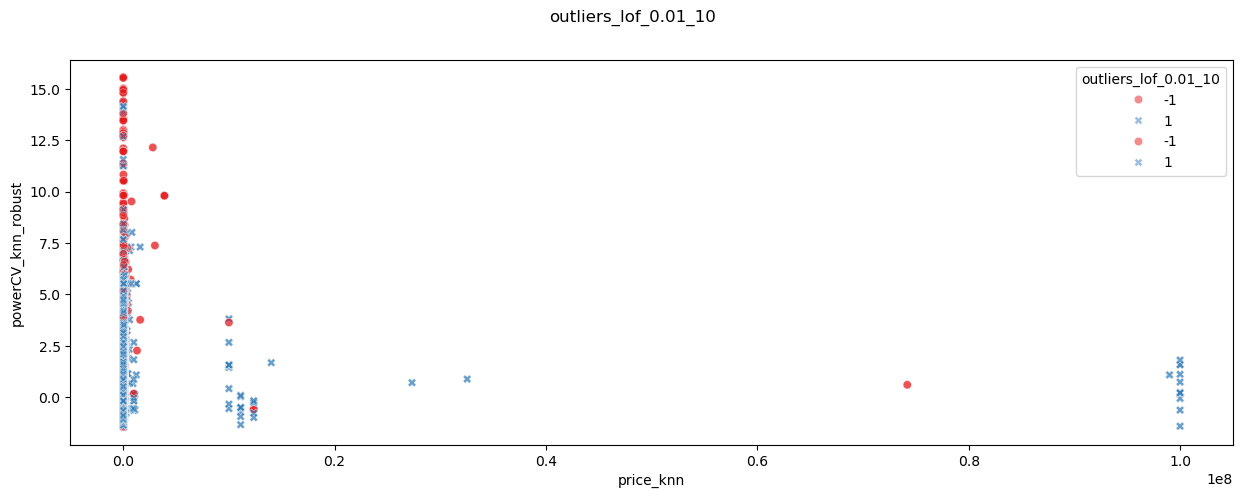

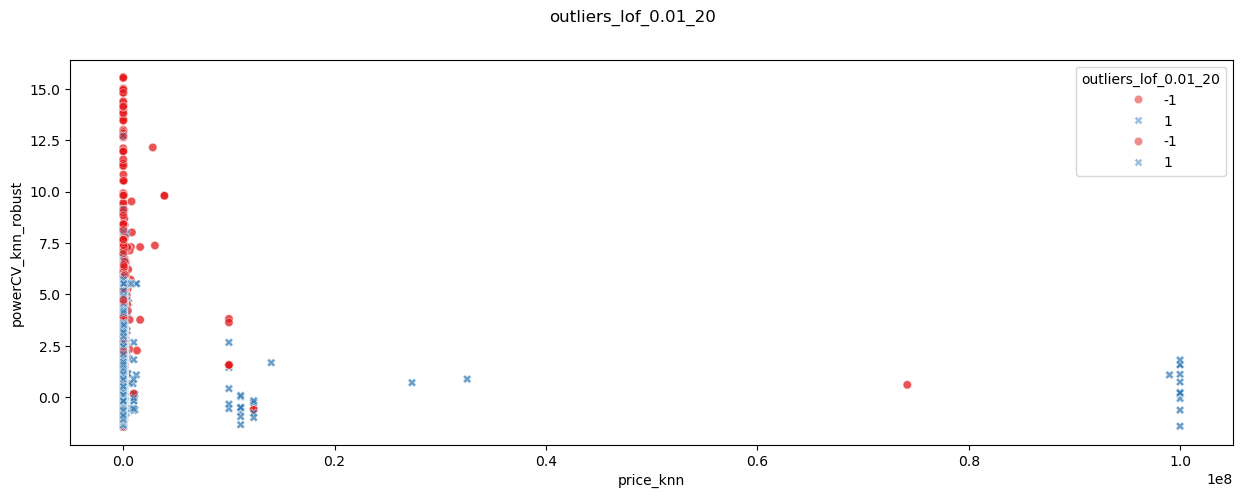

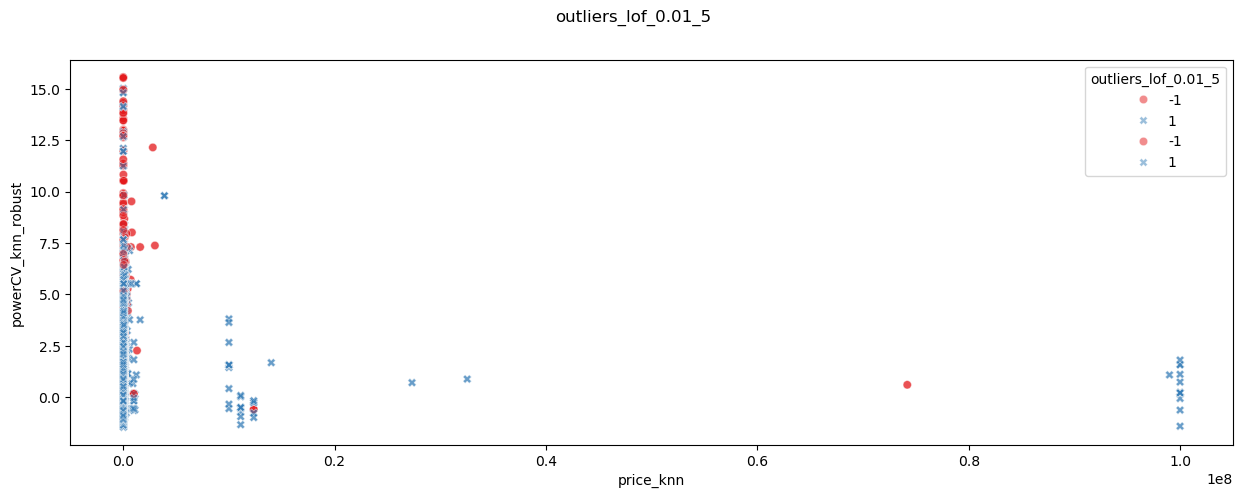

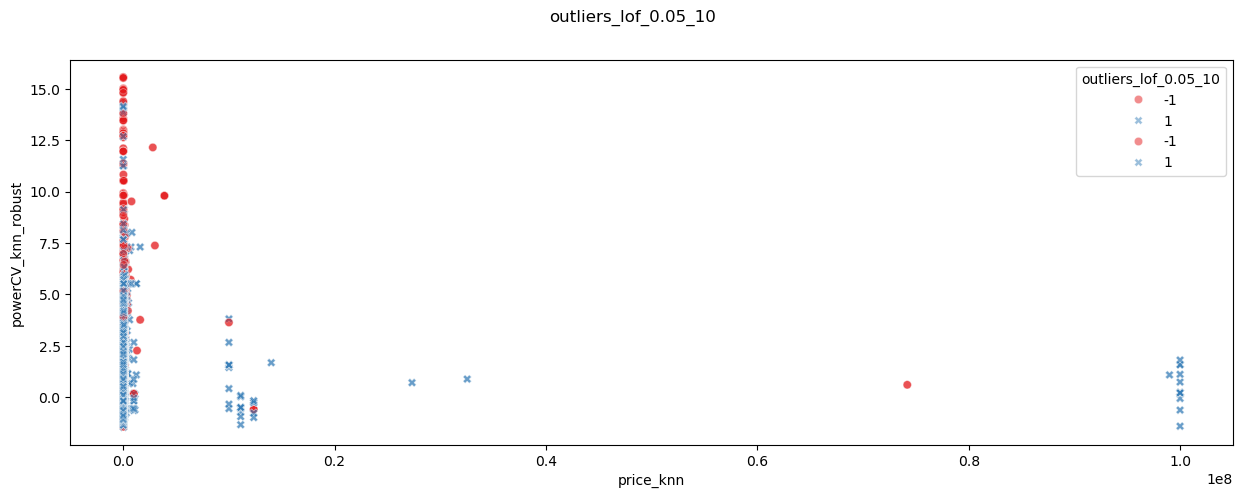

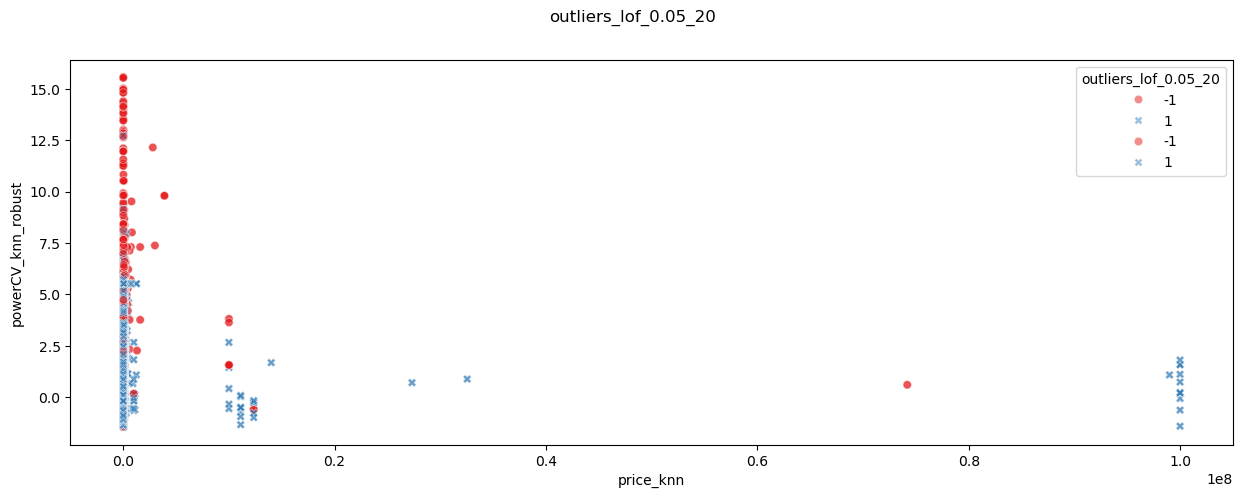

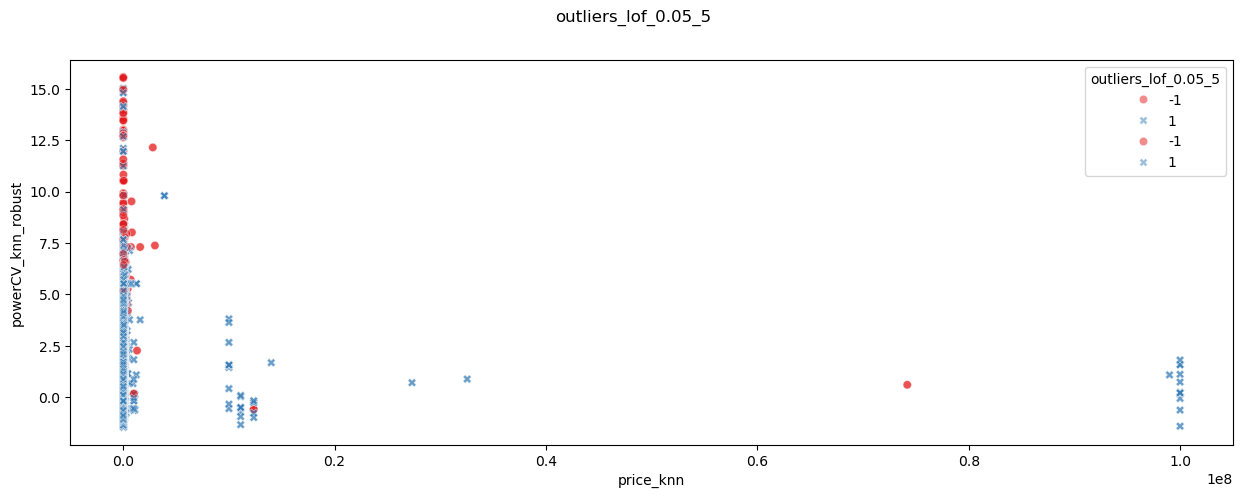

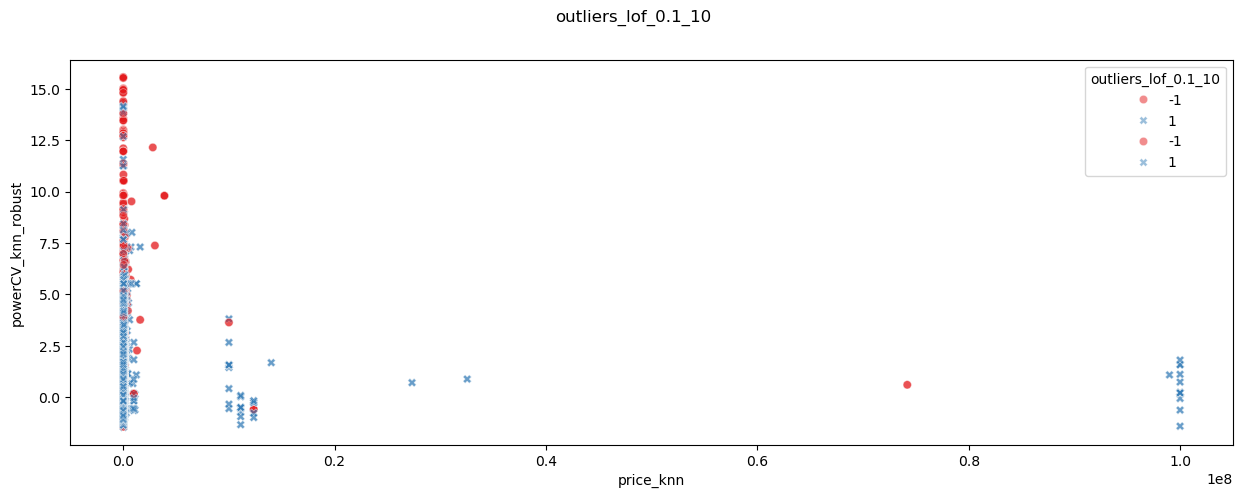

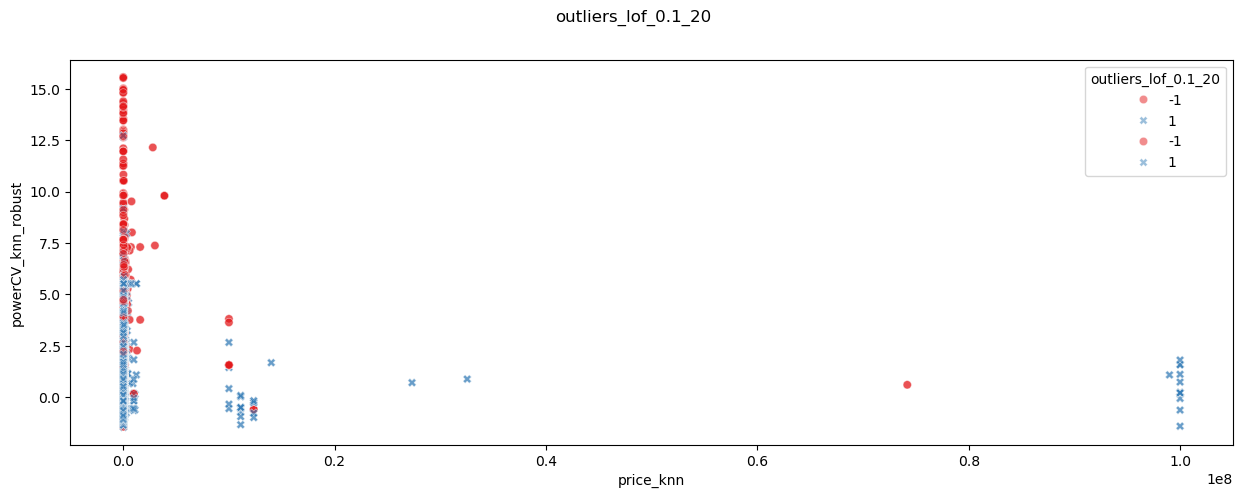

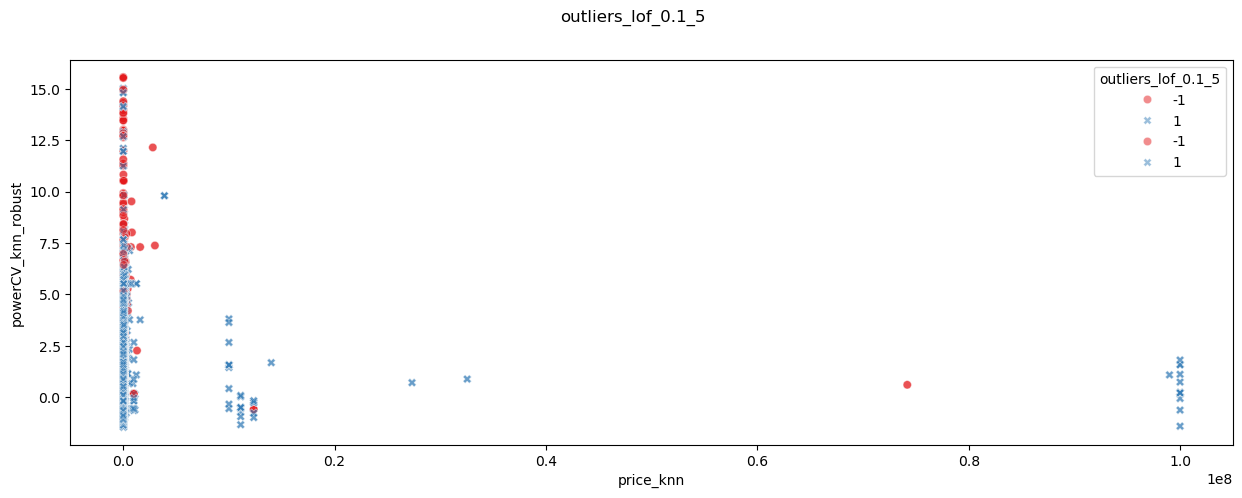

In [20]:
lista = ["price_knn","powerCV_knn_robust"]
columnas_hue = df_test_lof.filter(like="outlier").columns


for outlier in columnas_hue:
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize =  (15,5))
    # axes = axes.flat

    for indice, tupla in enumerate(lista):
        sns.scatterplot ( x= lista[0],
                         y = lista [1],
                        #  ax = axes[indice],
                         data= df_test_lof,
                         hue = outlier,
                         palette = "Set1",
                         style = outlier,
                         alpha = 0.5)
        
    plt.suptitle(outlier)


Elegimos el método LOF porque es más conservador con los datos. Esto puede ser debido a que no existen muchos subgrupos con los que relacionar el outlier, y no son datos dispersos, por lo que el algoritmo no funciona correctamente. Sin embargo, la utilización de un isolation forest tampoco sería adecuada, pues al ser datos bivariados el algoritmo no es del todo exacto, asimismo al ser datos no muy separados se puede requerir de muchos árboles de decisión para establecer un criterio adecuado, lo que implicaría demasiado tiempo y fuerza computacional. Por tanto, buscando también mantener cierta cantidad de outliers (Por eso también hemos usado estandarización robusta) usaremos el LOF por ser más conservador.   

In [29]:
# Seleccionamos las columnas que contienen "outlier"
outlier_columns = df_test_lof.filter(like="outlier")

# Filtramos las filas donde todas las columnas seleccionadas tienen el valor -1
rows_with_all_minus_one = outlier_columns[(outlier_columns == -1).all(axis=1)]
display(rows_with_all_minus_one.reset_index())
#Eliminamos los "outliers absolutos"
df_test_lof.drop(rows_with_all_minus_one.index,inplace = True)

,index,outliers_lof_0.01_10,outliers_lof_0.01_20,outliers_lof_0.01_5,outliers_lof_0.05_10,outliers_lof_0.05_20,outliers_lof_0.05_5,outliers_lof_0.1_10,outliers_lof_0.1_20,outliers_lof_0.1_5
0,1213,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1743,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1902,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2734,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2757,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
756,367315,-1,-1,-1,-1,-1,-1,-1,-1,-1
757,367894,-1,-1,-1,-1,-1,-1,-1,-1,-1
758,368623,-1,-1,-1,-1,-1,-1,-1,-1,-1
759,370271,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [31]:
# Seleccionamos las columnas relacionadas con "outlier", para ver aquellas que no tienen outliers absolutos
outlier_columns = df_test_lof.filter(like="outlier")

for columna in outlier_columns.columns:
    print(outlier_columns[columna].unique())

# Lista para almacenar las filas que contienen al menos un -1
filas_outliers = []

# Iterar sobre las filas del DataFrame
for index, row in outlier_columns.iterrows():
    # Verificar si alguna columna de la fila tiene el valor -1
    if (row.eq(-1).any()):
        filas_outliers.append(row)

# Convertir las filas seleccionadas en un nuevo DataFrame
df_outliers = pd.DataFrame(filas_outliers)

# Filtrar filas con al menos 80% valores -1
df_outliers = outlier_columns[outlier_columns.eq(-1).sum(axis=1) >= 7]

# Mostrar el DataFrame con las filas que tienen al menos seis -1
display (df_outliers)


[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]
[ 1 -1]


,outliers_lof_0.01_10,outliers_lof_0.01_20,outliers_lof_0.01_5,outliers_lof_0.05_10,outliers_lof_0.05_20,outliers_lof_0.05_5,outliers_lof_0.1_10,outliers_lof_0.1_20,outliers_lof_0.1_5


Habiendo seleccionado todos los outliers, son todos absolutos, por lo que al eliminarlos no tenemos más outliers según el criterio LOF empleado.